In [14]:
# Wholesale Customer Data Clustering Project
# Alan Shirk - alans@pdx.edu

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist

# Load Wholesale Customers dataset
data = pd.read_csv("/content/drive/MyDrive/Data Clustering/Project/Wholesale customers data.csv")

# Drop 'Channel' and 'Region' columns to focus on purchasing behavior and avoid noise from integer values
X_raw = data.drop(columns=["Channel", "Region"]).values

# Scale features to standard normal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

   k                   init  silhouette_mean     sse_mean
0  2     kmeans_random_init         0.536329  1986.428523
1  3     kmeans_random_init         0.455396  1638.000422
2  4     kmeans_random_init         0.359872  1353.283286
3  5     kmeans_random_init         0.342555  1141.779209
4  6     kmeans_random_init         0.310769   997.255433
5  2  kmeans_plus_plus_init         0.625510  2028.018693
6  3  kmeans_plus_plus_init         0.486498  1658.537537
7  4  kmeans_plus_plus_init         0.365922  1366.311197
8  5  kmeans_plus_plus_init         0.343737  1136.920989
9  6  kmeans_plus_plus_init         0.326368   976.655239


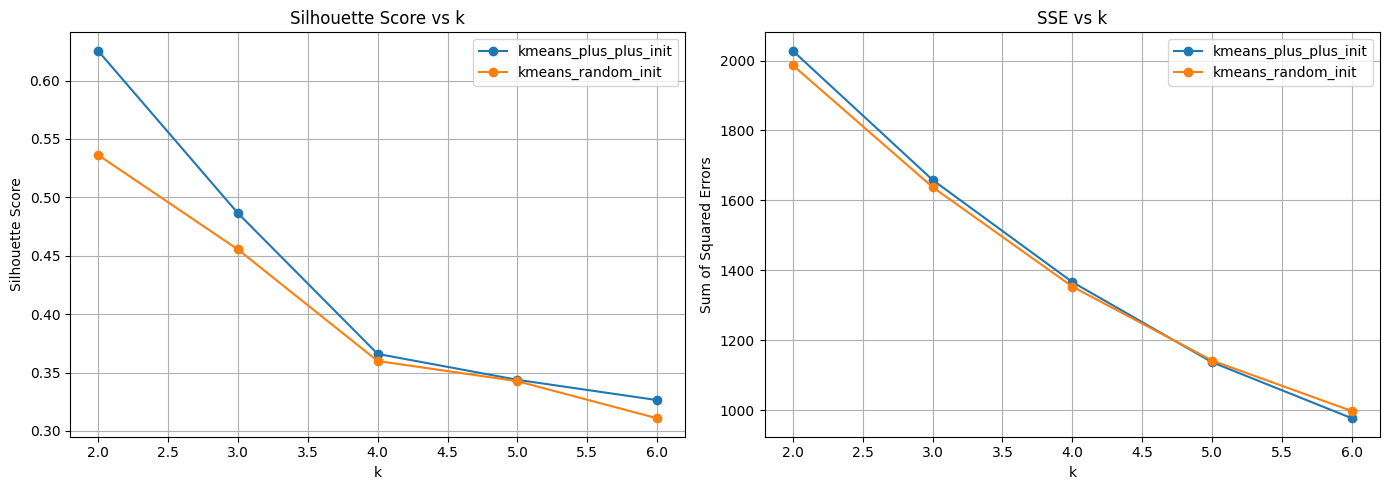

In [17]:
# K-means Implementation and Evaluation

# Random initialization
def kmeans_random_init(X, k, random_state=None):
    rng = np.random.default_rng(random_state)
    indices = rng.choice(X.shape[0], size=k, replace=False)
    return X[indices]

# K-means++ initialization
def kmeans_plus_plus_init(X, k, random_state=None):
    rng = np.random.default_rng(random_state)
    centers = [X[rng.integers(X.shape[0])]]
    while len(centers) < k:
        dist_sq = np.min([np.sum((X - c)**2, axis=1) for c in centers], axis=0)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)
        r = rng.random()
        next_idx = np.searchsorted(cumulative_probs, r)
        centers.append(X[next_idx])
    return np.array(centers)

# Lloyd's K-means algorithm
def lloyd_kmeans(X, initial_centers, max_iters=100, tol=1e-4):
    centers = initial_centers.copy()
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, None] - centers, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centers = np.array([X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j]
                                for j in range(len(centers))])
        if np.linalg.norm(new_centers - centers) <= tol:
            break
        centers = new_centers
    return centers, labels

# Compute SSE
def compute_sse(X, centers, labels):
    return np.sum((X - centers[labels])**2)

# Evaluate K-means (loop over k values and seeds)
def evaluate_kmeans(X, k_values, seeds, init_fn):
    results = []
    for k in k_values:
        sils, sses = [], []
        for seed in seeds:
            init_centers = init_fn(X, k, random_state=seed)
            centers, labels = lloyd_kmeans(X, init_centers)
            sils.append(silhouette_score(X, labels))
            sses.append(compute_sse(X, centers, labels))
        results.append({
            'k': k,
            'init': init_fn.__name__,
            'silhouette_mean': np.mean(sils),
            'sse_mean': np.mean(sses)
        })
    return results

# Run evaluations
k_values = [2, 3, 4, 5, 6]
seeds = list(range(10))

results_random = evaluate_kmeans(X_scaled, k_values, seeds, kmeans_random_init)
results_pp = evaluate_kmeans(X_scaled, k_values, seeds, kmeans_plus_plus_init)

# Combine results into DataFrame
df_kmeans = pd.DataFrame(results_random + results_pp)
print(df_kmeans)

# Plot silhouette scores and SSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette scores
for name, group in df_kmeans.groupby("init"):
    axes[0].plot(group["k"], group["silhouette_mean"], label=name, marker='o')
axes[0].set_title("Silhouette Score vs k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend()
axes[0].grid(True)

# SSE
for name, group in df_kmeans.groupby("init"):
    axes[1].errorbar(group["k"], group["sse_mean"], label=name, fmt='-o')
axes[1].set_title("SSE vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Sum of Squared Errors")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

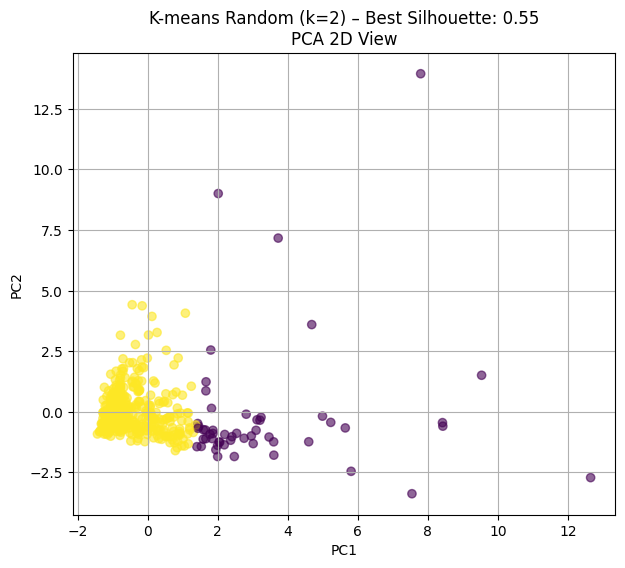

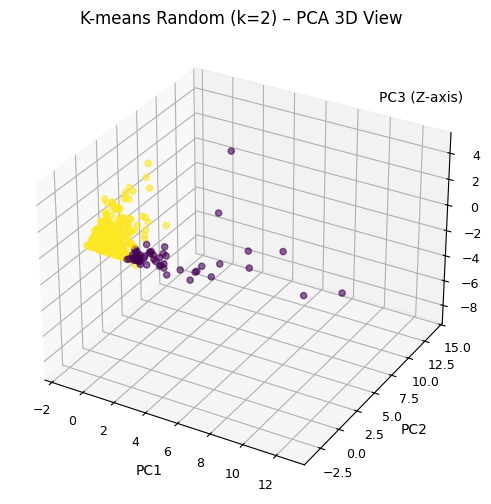

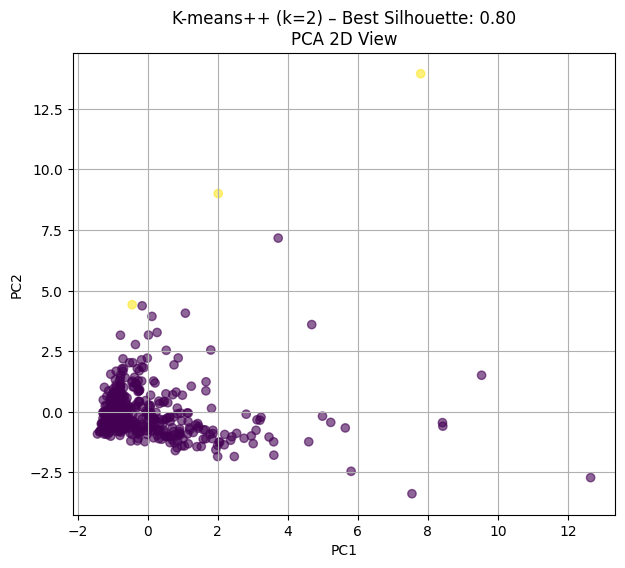

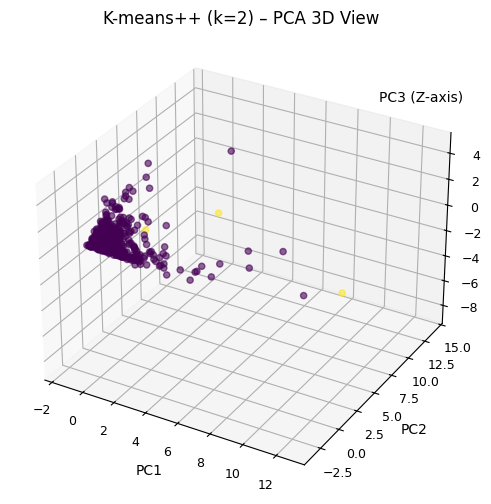

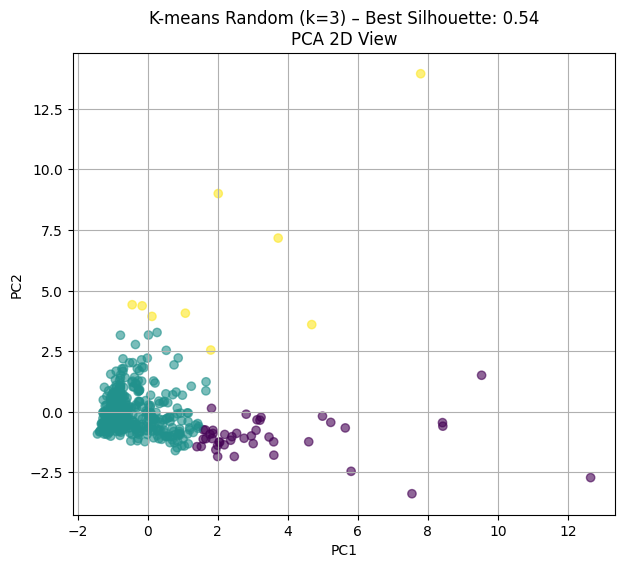

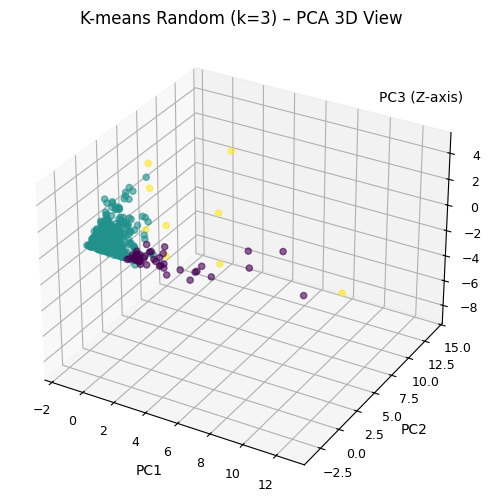

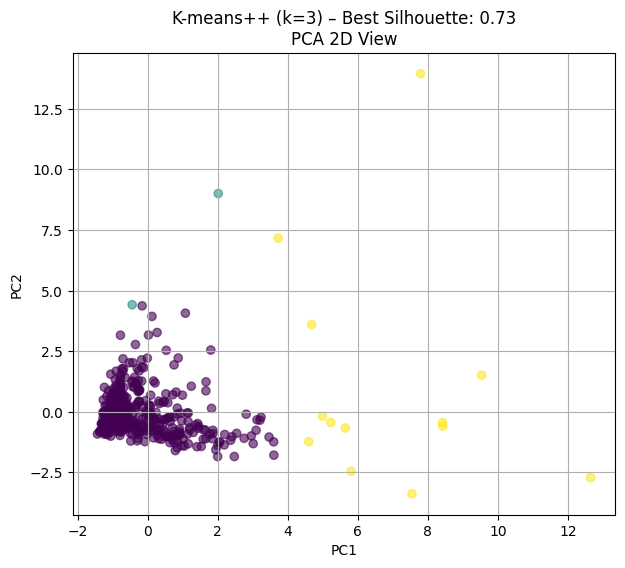

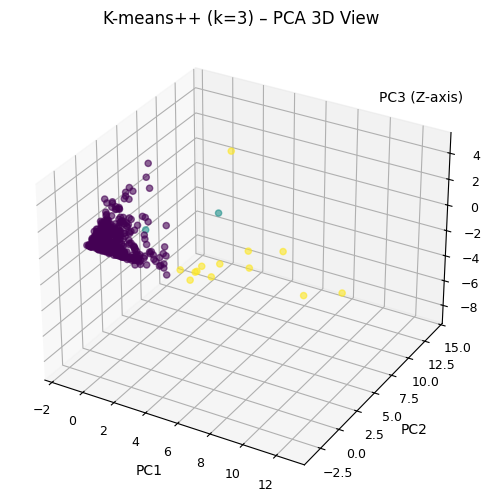

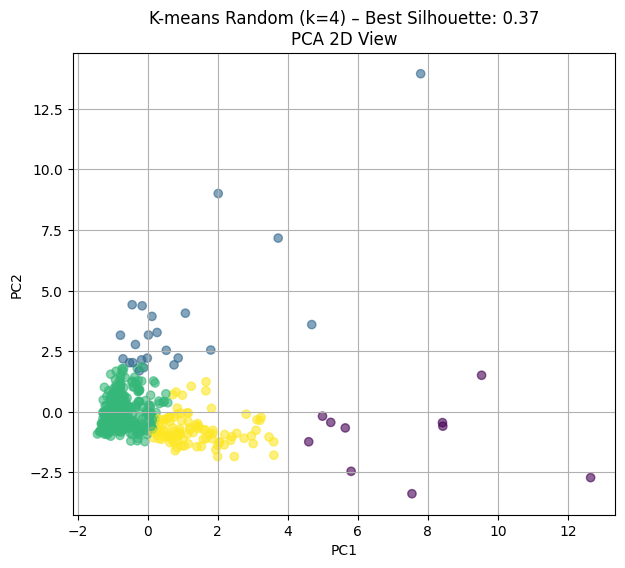

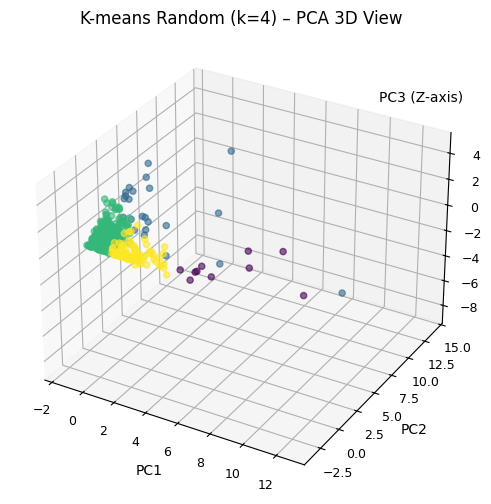

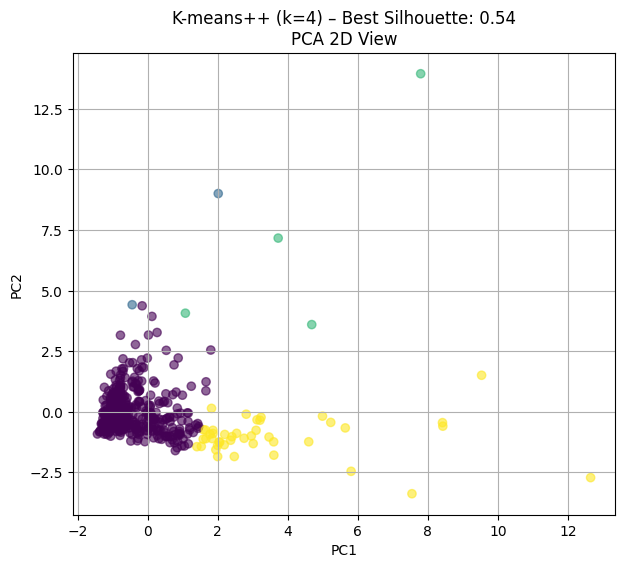

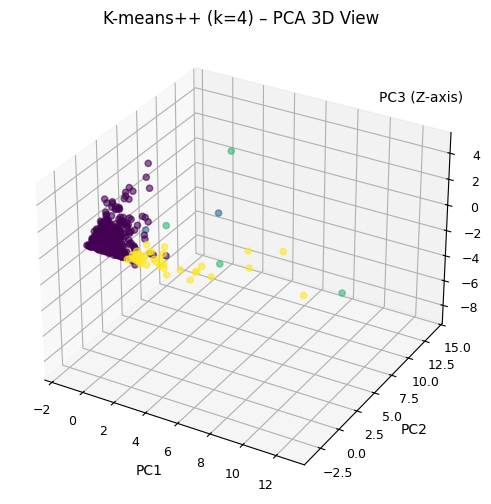

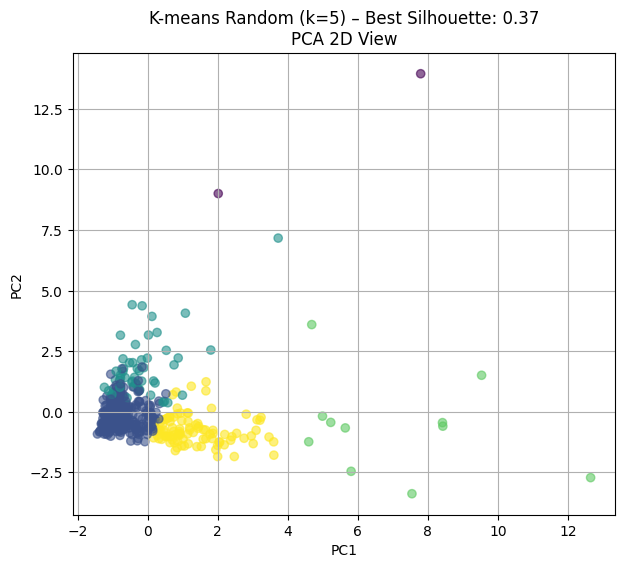

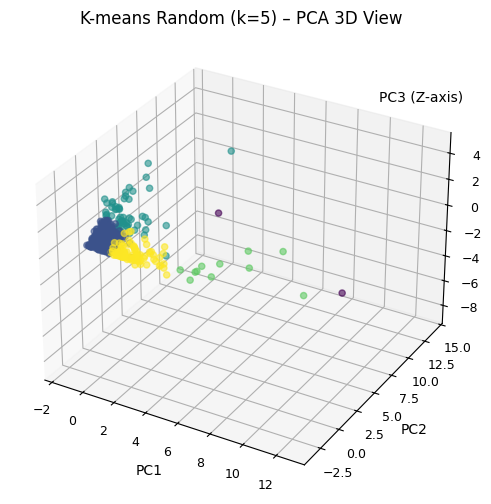

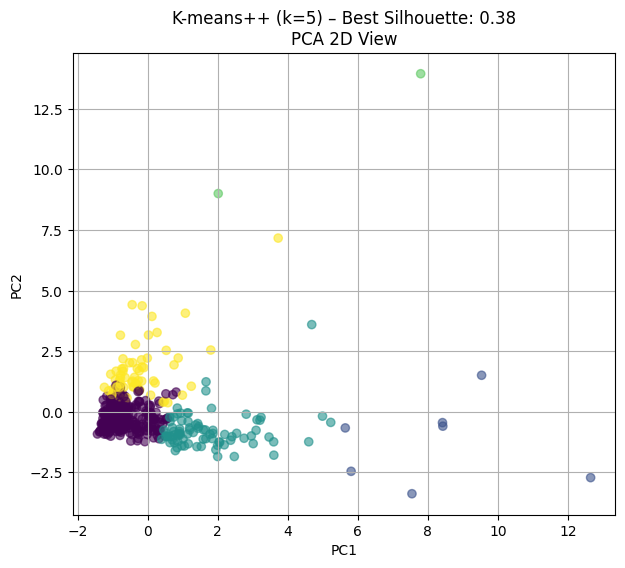

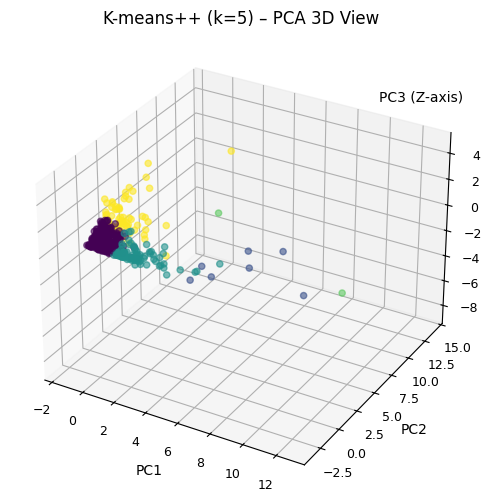

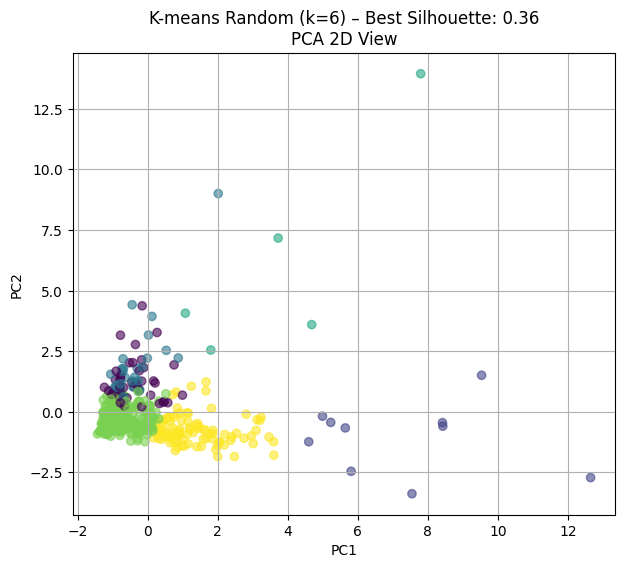

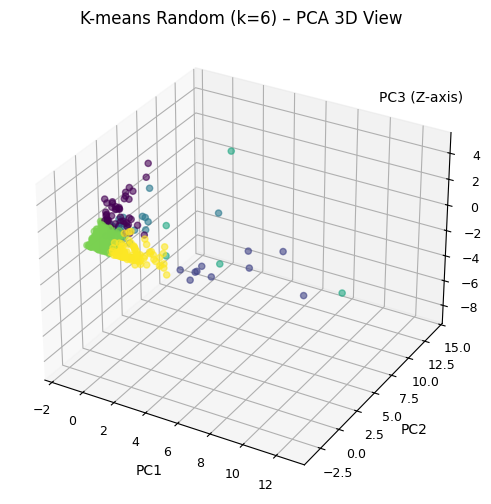

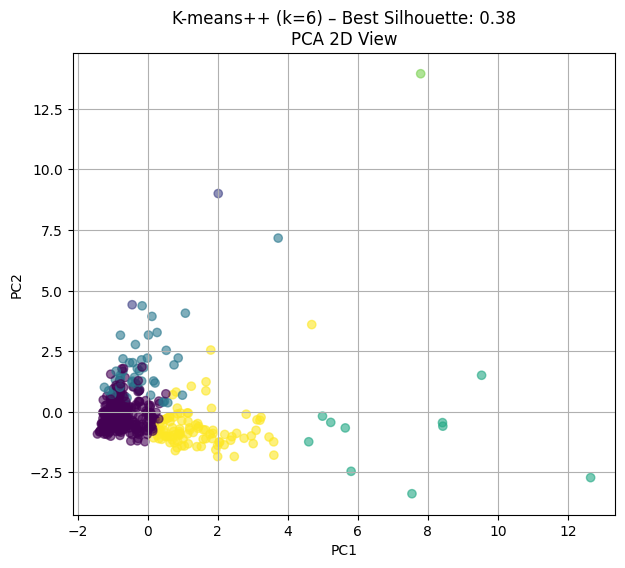

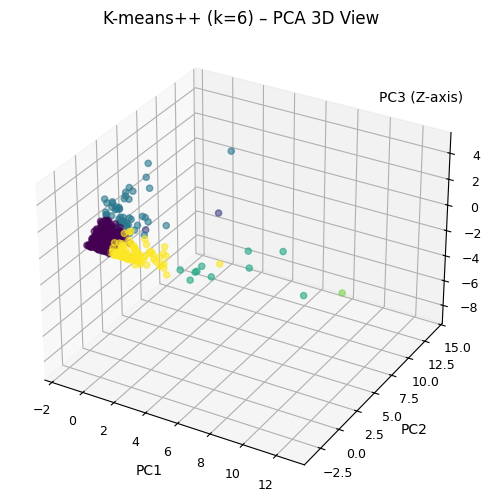

In [18]:
# 2D PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3D PCA projection
pca_3d = PCA(n_components=3)
X_3D = pca_3d.fit_transform(X_scaled)

for k in range(2, 7):
    for init_fn, init_name in [(kmeans_random_init, "K-means Random"), (kmeans_plus_plus_init, "K-means++")]:
        best_score = -1
        best_labels = None

        for seed in seeds:
            init_centers = init_fn(X_scaled, k, random_state=seed)
            centers, labels = lloyd_kmeans(X_scaled, init_centers)
            sil = silhouette_score(X_scaled, labels)

            if sil > best_score:
                best_score = sil
                best_labels = labels

        # 2D PCA Plot
        plt.figure(figsize=(7, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.6)
        plt.title(f"{init_name} (k={k}) – Best Silhouette: {best_score:.2f}\nPCA 2D View")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.show()

        # 3D PCA Plot
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=best_labels, cmap='viridis', alpha=0.6)
        ax.set_title(f"{init_name} (k={k}) – PCA 3D View")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.tick_params(labelsize=9)
        ax.text2D(0.98, 0.85, "PC3 (Z-axis)", transform=ax.transAxes, fontsize=10, ha='right')
        plt.show()

In [19]:
# Hierarchical Agglomerative Clustering (HAC)

# HAC with average and complete linkage
def hac_custom_linkage(X, method="average"):
    n = X.shape[0]
    dist_matrix = cdist(X, X)
    clusters = [[i] for i in range(n)]
    merge_history = []

    while len(clusters) > 1:
        min_dist = float("inf")
        to_merge = (None, None)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                if method == "average":
                    dist = np.mean([dist_matrix[p1, p2] for p1 in clusters[i] for p2 in clusters[j]])
                elif method == "complete":
                    dist = np.max([dist_matrix[p1, p2] for p1 in clusters[i] for p2 in clusters[j]])
                else:
                    raise ValueError("Unsupported method")
                if dist < min_dist:
                    min_dist = dist
                    to_merge = (i, j)

        i, j = to_merge
        new_cluster = clusters[i] + clusters[j]
        merge_history.append((clusters[i], clusters[j], min_dist))
        clusters.pop(max(i, j))
        clusters.pop(min(i, j))
        clusters.append(new_cluster)

    return merge_history, n

# Convert merge history to linkage matrix for dendrogram
def build_linkage_matrix(merge_history, n_samples):
    linkage_matrix = np.zeros((len(merge_history), 4))
    cluster_id = {tuple([i]): i for i in range(n_samples)}
    next_cluster_id = n_samples
    for i, (c1, c2, dist) in enumerate(merge_history):
        id1 = cluster_id[tuple(sorted(c1))]
        id2 = cluster_id[tuple(sorted(c2))]
        new_cluster = tuple(sorted(c1 + c2))
        linkage_matrix[i] = [id1, id2, dist, len(new_cluster)]
        cluster_id[new_cluster] = next_cluster_id
        next_cluster_id += 1
    return linkage_matrix

# Convert cluster list to flat labels
def get_clusters_from_merge_history(merge_history, n_samples, k):
    clusters = [[i] for i in range(n_samples)]
    for merge in merge_history[:n_samples - k]:
        c1, c2, _ = merge
        i1 = next(i for i, c in enumerate(clusters) if set(c) == set(c1))
        i2 = next(i for i, c in enumerate(clusters) if set(c) == set(c2))
        new_cluster = clusters[i1] + clusters[i2]
        clusters.pop(max(i1, i2))
        clusters.pop(min(i1, i2))
        clusters.append(new_cluster)
    return clusters

def assign_cluster_labels(clusters, n_samples):
    labels = np.empty(n_samples, dtype=int)
    for idx, cluster in enumerate(clusters):
        for point in cluster:
            labels[point] = idx
    return labels

Running HAC Average-Linkage...


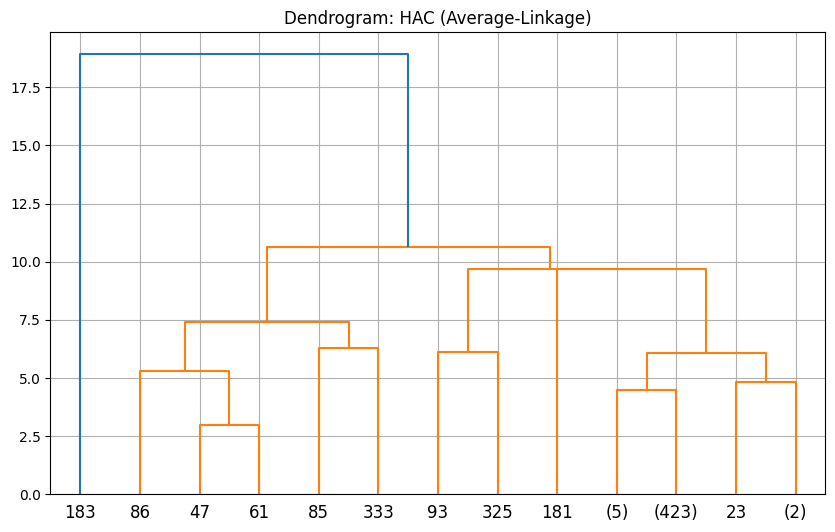

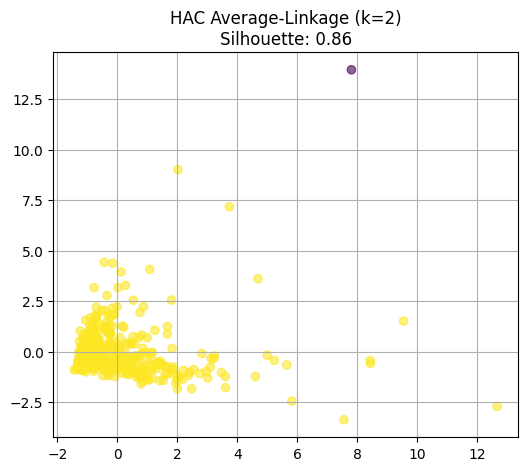

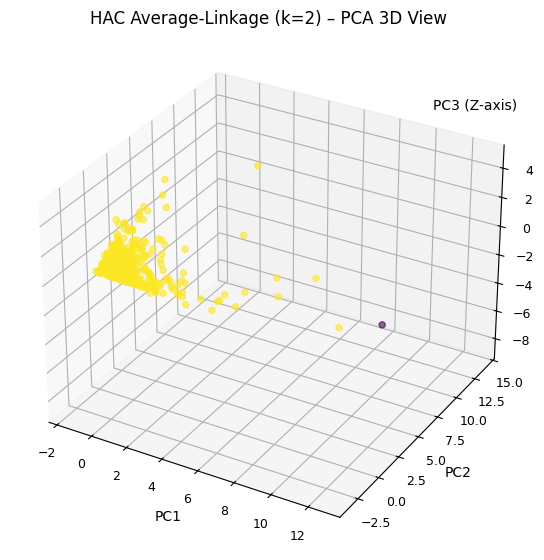

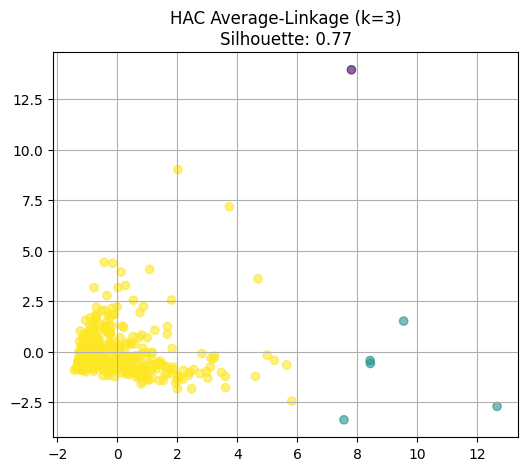

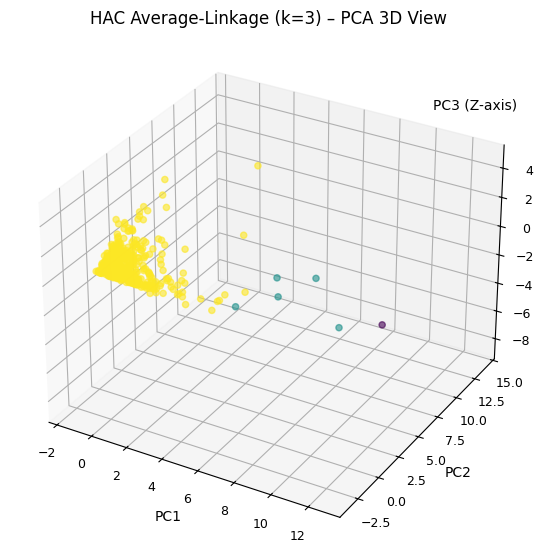

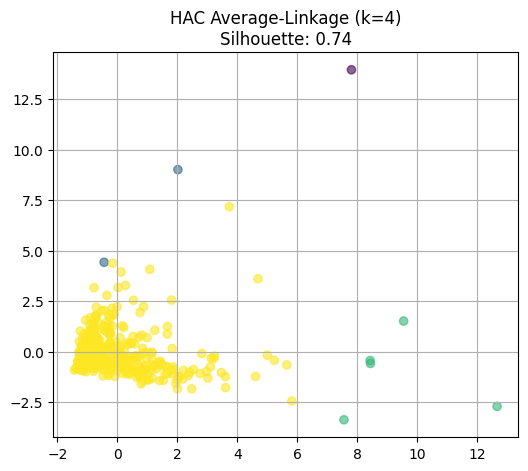

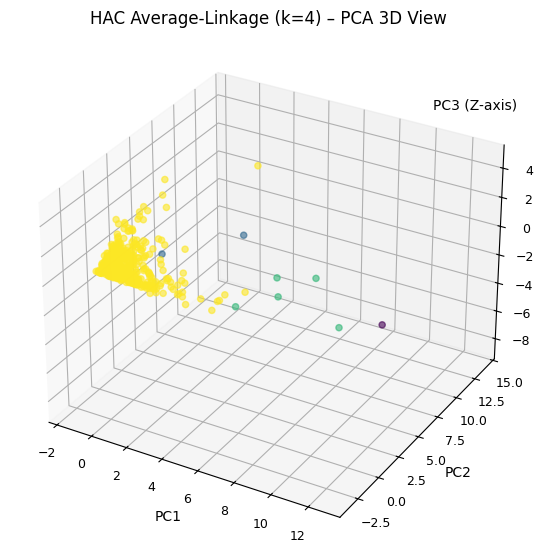

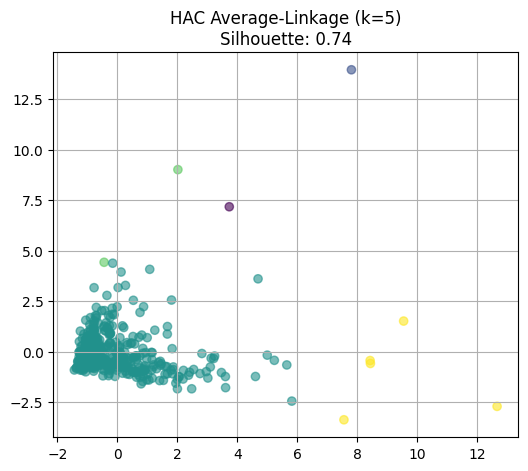

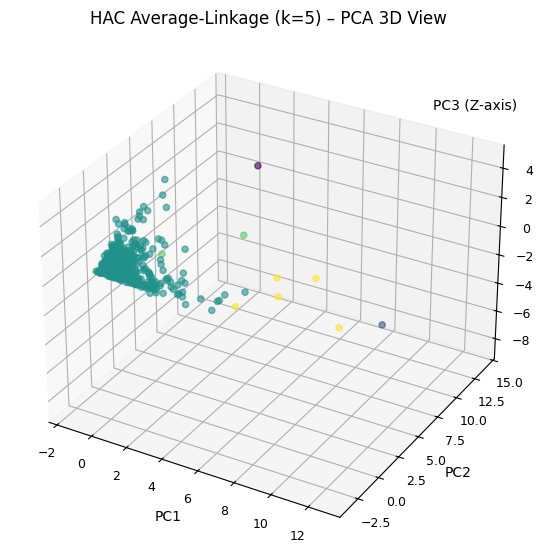

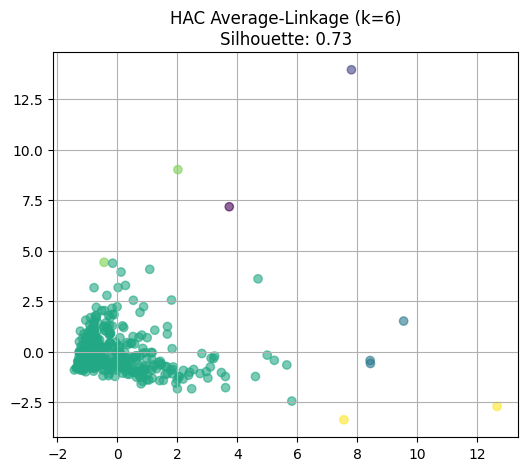

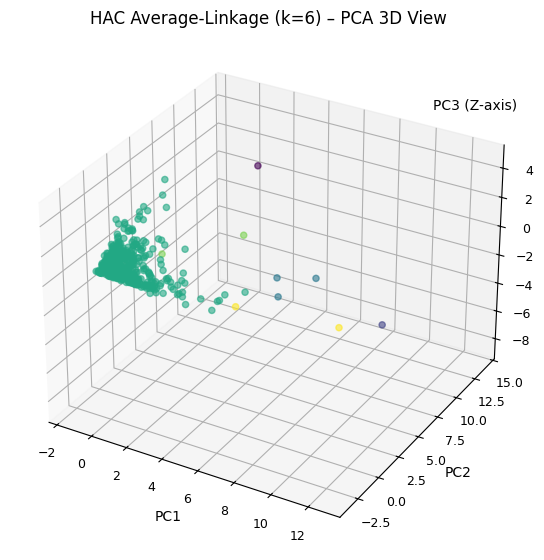

In [20]:
# HAC Average-Linkage Evaluation
pca_3d = PCA(n_components=3)
X_3D = pca_3d.fit_transform(X_scaled)

# Run HAC Average-Linkage
print("Running HAC Average-Linkage...")
merge_history_avg, n_samples = hac_custom_linkage(X_scaled, method="average")
linkage_matrix_avg = build_linkage_matrix(merge_history_avg, n_samples)
hac_avg_results = []

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_avg, truncate_mode='level', p=5)
plt.title("Dendrogram: HAC (Average-Linkage)")
plt.grid(True)
plt.show()

# Evaluate each k
for k in k_values:
    clusters = get_clusters_from_merge_history(merge_history_avg, n_samples, k)
    labels = assign_cluster_labels(clusters, n_samples)
    sil = silhouette_score(X_scaled, labels)
    hac_avg_results.append({'method': 'HAC Average', 'k': k, 'silhouette': sil})

    # 2D PCA
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f"HAC Average-Linkage (k={k})\nSilhouette: {sil:.2f}")
    plt.grid(True)
    plt.show()

    # 3D PCA
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(f"HAC Average-Linkage (k={k}) – PCA 3D View")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.tick_params(labelsize=9)
    ax.text2D(0.98, 0.85, "PC3 (Z-axis)", transform=ax.transAxes, fontsize=10, ha='right')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Running HAC Complete-Linkage...


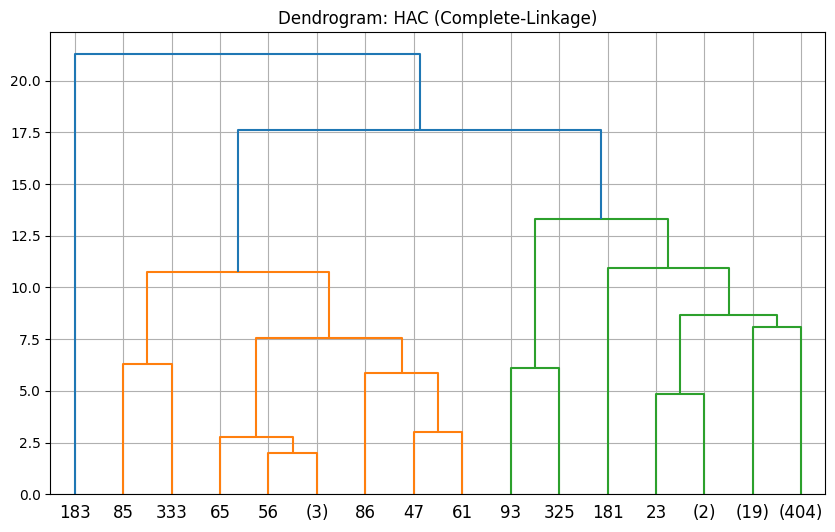

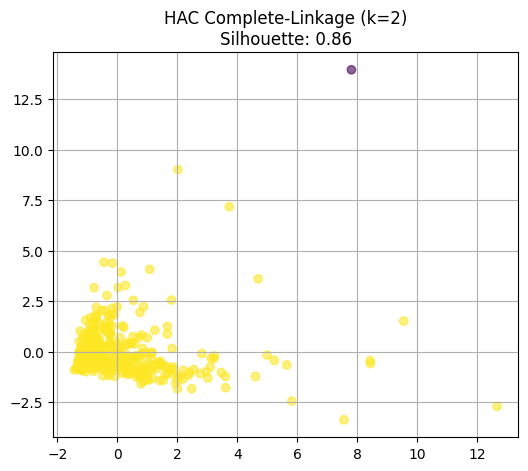

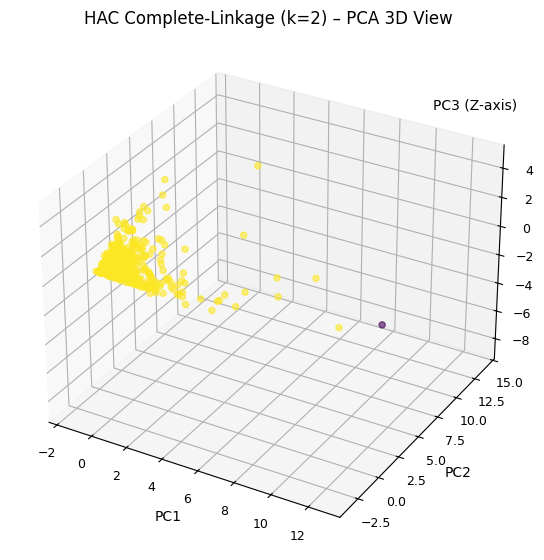

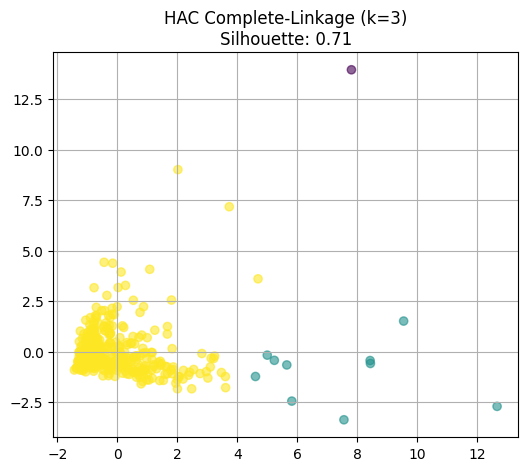

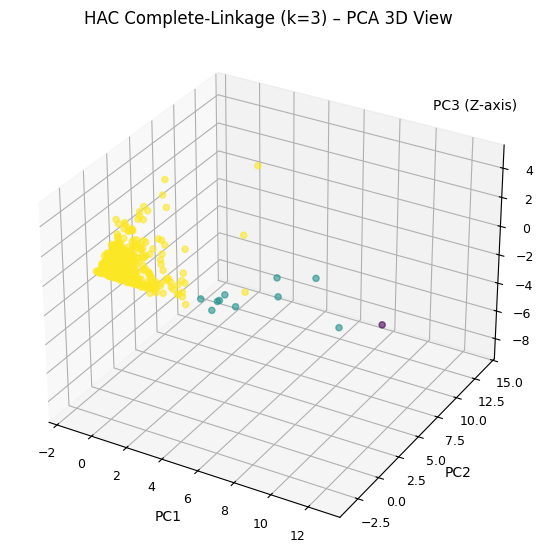

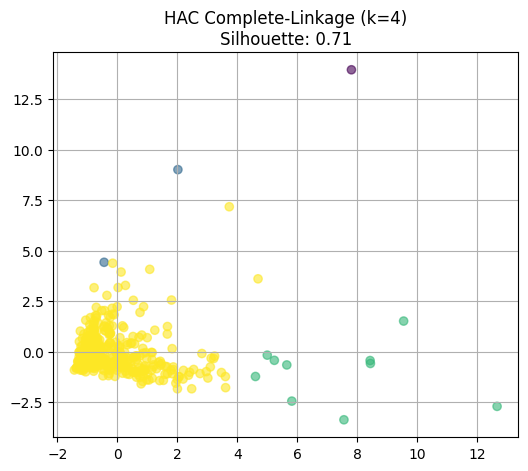

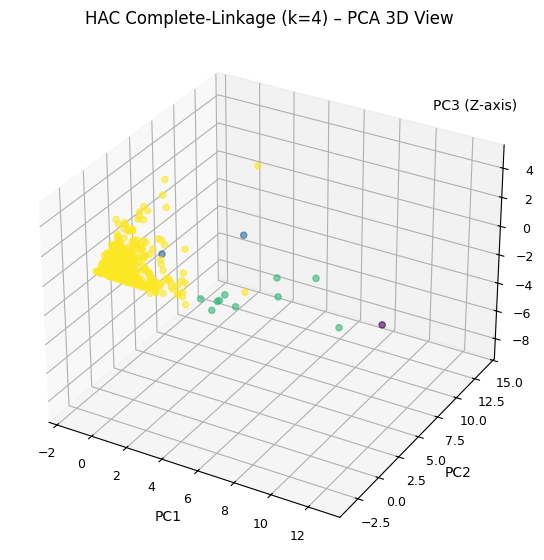

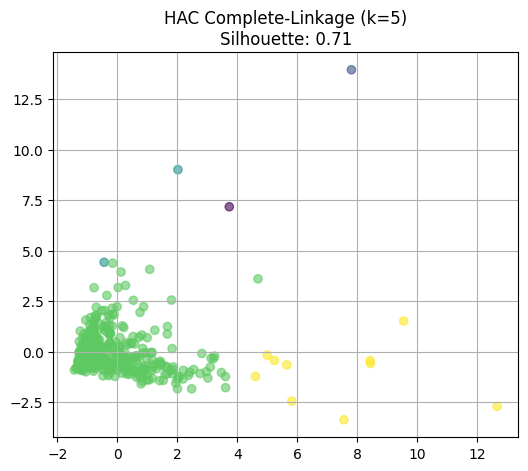

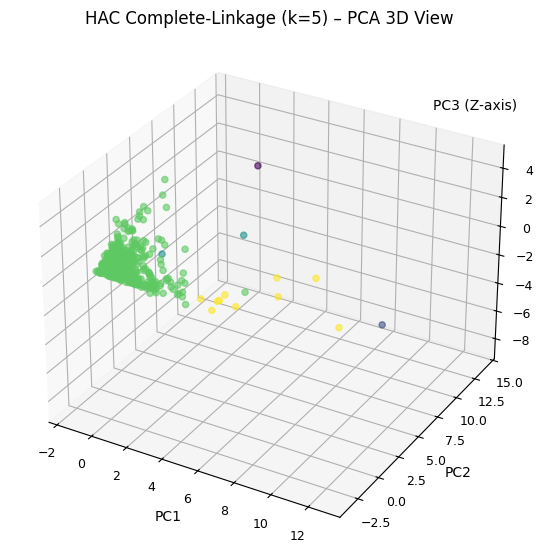

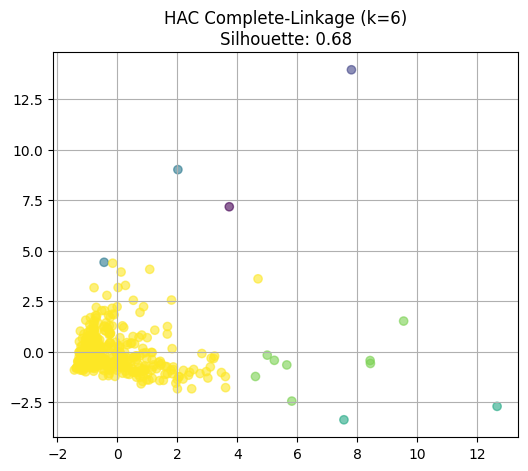

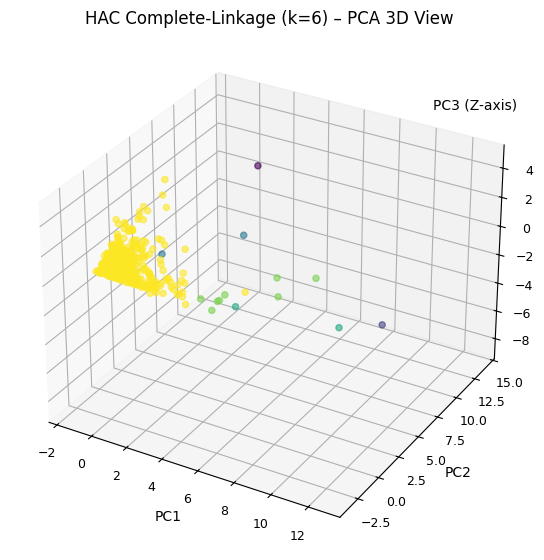

In [21]:
# HAC Complete-Linkage Evaluation

# Run HAC Complete-Linkage
print("Running HAC Complete-Linkage...")
merge_history_complete, n_samples = hac_custom_linkage(X_scaled, method="complete")
linkage_matrix_complete = build_linkage_matrix(merge_history_complete, n_samples)
hac_complete_results = []

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_complete, truncate_mode='level', p=5)
plt.title("Dendrogram: HAC (Complete-Linkage)")
plt.grid(True)
plt.show()

# Evaluate each k
for k in k_values:
    clusters = get_clusters_from_merge_history(merge_history_complete, n_samples, k)
    labels = assign_cluster_labels(clusters, n_samples)
    sil = silhouette_score(X_scaled, labels)
    hac_complete_results.append({'method': 'HAC Complete', 'k': k, 'silhouette': sil})

    # 2D PCA
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f"HAC Complete-Linkage (k={k})\nSilhouette: {sil:.2f}")
    plt.grid(True)
    plt.show()

    # 3D PCA
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(f"HAC Complete-Linkage (k={k}) – PCA 3D View")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.tick_params(labelsize=9)
    ax.text2D(0.98, 0.85, "PC3 (Z-axis)", transform=ax.transAxes, fontsize=10, ha='right')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

        method  k  silhouette
   HAC Average  2    0.863801
  HAC Complete  2    0.863801
     K-means++  2    0.625510
K-means Random  2    0.536329
   HAC Average  3    0.767580
  HAC Complete  3    0.711531
     K-means++  3    0.486498
K-means Random  3    0.455396
   HAC Average  4    0.744734
  HAC Complete  4    0.711863
     K-means++  4    0.365922
K-means Random  4    0.359872
   HAC Average  5    0.736779
  HAC Complete  5    0.708506
     K-means++  5    0.343737
K-means Random  5    0.342555
   HAC Average  6    0.730560
  HAC Complete  6    0.679294
     K-means++  6    0.326368
K-means Random  6    0.310769


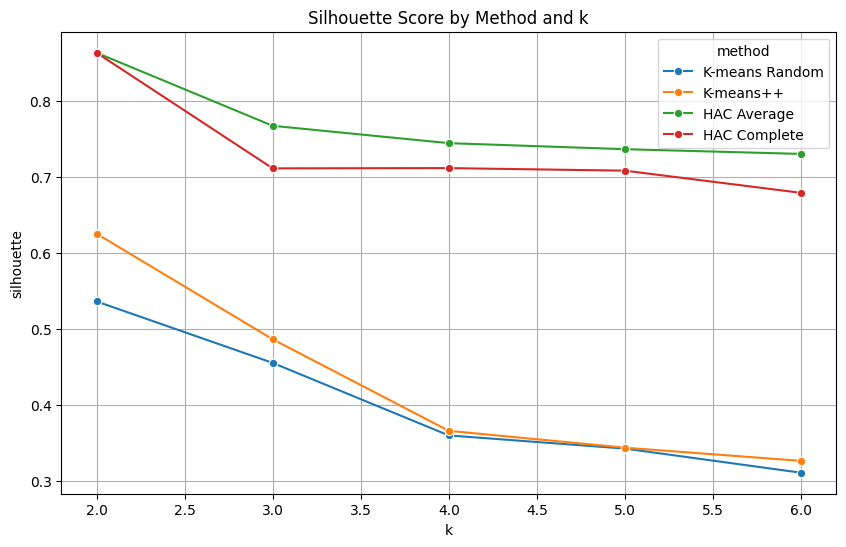

In [22]:
# Combine results into Dataframe
hac_df = pd.DataFrame(hac_avg_results + hac_complete_results)
kmeans_df = df_kmeans.copy()
kmeans_df["method"] = kmeans_df["init"].map({
    "kmeans_random_init": "K-means Random",
    "kmeans_plus_plus_init": "K-means++"
})
kmeans_summary = kmeans_df[["method", "k", "silhouette_mean"]].rename(columns={"silhouette_mean": "silhouette"})

df_all = pd.concat([kmeans_summary, hac_df], ignore_index=True)
print(df_all.sort_values(by=["k", "silhouette"], ascending=[True, False]).to_string(index=False))

# Plot silhouette comparison
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x='k', y='silhouette', hue='method', marker='o')
plt.title("Silhouette Score by Method and k")
plt.grid(True)
plt.show()